# SkimLit 📄🔥

* Break down research papers (medical abstract) into more understandable or digestable sections

### What steps are we taking?

1. Downloading a text dataset (PubMed 200K RCT)
2. Writing a preprocessing function for our text data
3. Set up multiple modelling experiments with different levels of embeddings
4. Buld a multimodal model to take in different sources of data
5. Replicate the model powering https://arxiv.org/abs/1710.06071
6. Find the most wrong predictions

## Get the Data

Luckily for us, the author of the research paper has made the dataset publicly available: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 7.11 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [11]:
#We're starting with the smaller dataset for quicker testing, lets see what is in it!
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt   test.txt  train.txt


In [1]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [2]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/.ipynb_checkpoints']

## Preprocess Data

Let's get an idea for the dataset by Visualizing

In [3]:
#Function to read lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of text as a list.

    Args:
        filename: a string containing the target filepath.

    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, 'r') as f:
        return f.readlines()

In [4]:
#Read in the training lines
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [5]:
len(train_lines)

210040

How will we separate the label from the text? 

```
[{'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
    'total_lines': 11},
    ...]
```

In [6]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    
    #Split lines from the given file into individual abstract lines
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            #Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) -1
                abstract_samples.append(line_data)

        else:
            abstract_lines += line

    return  abstract_samples        

In [7]:
# Get the data and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [8]:
#Check the first abstract of training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

### Now that the data is in a list of dictionaries we can turn it into a DataFrame for better visualization

In [9]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [10]:
#Distribution of labels
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

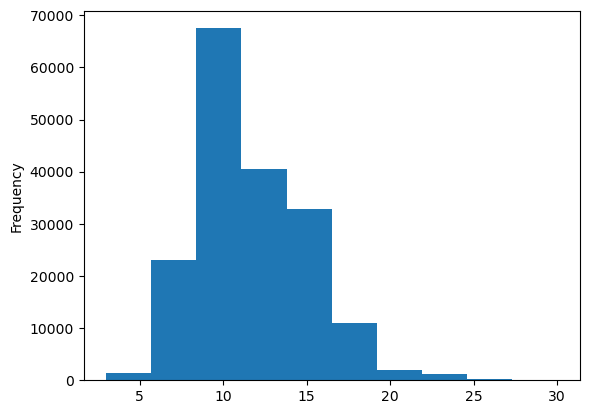

In [11]:
# What about the length of different lines?
train_df.total_lines.plot.hist()

### Get lists of sentences

In [12]:
# Convert abstracts to lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [13]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make our Data Labels numeric

In [14]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [15]:
# Label encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [16]:
#Get Class names and number of classes from the Label Encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model Building Experiments

What will we be building?

* Baseline: Naive Bayes with TF-IDF encoder
1. Conv1D with token embeddings
2. TensorFlow Hub Pretrained Feature Extractor
3. Conv1D with character embeddings
4. Pretrained token embeddings (same as 2) + character embeddings (same as 3)
5. Pretrained token embeddings + character embeddings + positional embeddings

### Baseline Model

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [18]:
baseline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

baseline.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
baseline_score = baseline.score(val_sentences, val_labels_encoded)
print(f'Baseline Model Achieves an Accuracy Score of: {baseline_score*100: .2f}%')

Baseline Model Achieves an Accuracy Score of:  72.18%


In [20]:
# Make predictions using the baseline model
baseline_preds = baseline.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [21]:
from sklearn.metrics import classification_report
print(classification_report(val_labels_encoded, baseline_preds))

              precision    recall  f1-score   support

           0       0.66      0.49      0.56      3449
           1       0.65      0.59      0.61      4582
           2       0.72      0.87      0.79      9964
           3       0.75      0.14      0.23      2376
           4       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



### Tokenize the text then turn it into an embedding

**Tokenization**

In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np

#length of all sentences
total = round(sum([len(i.split()) for i in train_sentences]))
print(total)

#average length of sentences
average_len = round(total/len(train_sentences))
print(average_len)

4741942
26


In [18]:
sen_lens = [len(sentence.split()) for sentence in train_sentences]

#What number covers 95% of our data?
output_seq_len = int(np.percentile(sen_lens, 95))
output_seq_len

55

In [19]:
max_vocab_len = 68000 #From table 2 in the paper: https://arxiv.org/abs/1710.06071
max_len = 55

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_len,
    output_sequence_length=max_len
)

In [20]:
text_vectorizer.adapt(train_sentences)

In [21]:
#Display random sentence being vectorized
import random

random_sentence = random.choice(train_sentences)
print(f'Original Sentence:\n {random_sentence}\n\nVectorized Version:')
text_vectorizer(random_sentence)

Original Sentence:
 patients expressing h@ received a @-week induction course of intravesical bc-@ .

Vectorized Version:


<tf.Tensor: shape=(55,), dtype=int64, numpy=
array([   12,  6296,   196,    80,     8,    89,   778,   656,     4,
       12058,  3639,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])>

In [22]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_10_words = words_in_vocab[:10]
bottom_10_words = words_in_vocab[-10:]

print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_10_words}')
print(f'5 least common words: {bottom_10_words}')

Number of words in vocab: 64841
5 most common words: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
5 least common words: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


**Embedding**

In [23]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_len, output_dim=128, mask_zero=True)

embedding

In [24]:
random_sentence = random.choice(train_sentences)
print(f'Original Sentence:\n {random_sentence}\n\nVectorized Version:')
print(text_vectorizer(random_sentence))
print(f'\nEmbedding Version:')
embedding(text_vectorizer(random_sentence))

Original Sentence:
 adherence to ex was determined from exercise logs , ambulatory heart rate recordings of exercise , and weekly telephone contacts .

Vectorized Version:
tf.Tensor(
[  429     6  3482    10   505    27   177 22648  1733   260    78  3870
     4   177     3   632  1032  4546     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(55,), dtype=int64)

Embedding Version:


<tf.Tensor: shape=(55, 128), dtype=float32, numpy=
array([[-0.01426382,  0.02036412,  0.02916726, ..., -0.04192965,
        -0.04415173,  0.02262126],
       [-0.01937443, -0.04639683, -0.03277738, ...,  0.0319826 ,
         0.02556853, -0.03052617],
       [ 0.04853087, -0.00911927, -0.01224303, ...,  0.02849119,
        -0.04674739, -0.04735545],
       ...,
       [ 0.03789096, -0.04744036, -0.0081799 , ..., -0.04134857,
         0.04950932, -0.04803448],
       [ 0.03789096, -0.04744036, -0.0081799 , ..., -0.04134857,
         0.04950932, -0.04803448],
       [ 0.03789096, -0.04744036, -0.0081799 , ..., -0.04134857,
         0.04950932, -0.04803448]], dtype=float32)>

### Conv1D with token embeddings

In [29]:
from tensorflow.keras.layers import Conv1D, Input, GlobalAveragePooling1D, Dense

inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = Conv1D(128, 5, padding='same', activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(5, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 128)           82048     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               16512 

In [31]:
model_1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = tf.keras.optimizers.legacy.Adam())

In [82]:
tf.random.set_seed(42)

history_1 = model_1.fit(tf.constant(train_sentences), train_labels_one_hot, epochs=5, validation_data=(tf.constant(val_sentences), val_labels_one_hot))

Epoch 1/5
5627/5627 [==============================] - 98s 17ms/step - loss: 0.3999 - accuracy: 0.8576 - val_loss: 0.5248 - val_accuracy: 0.8113
Epoch 2/5
5627/5627 [==============================] - 97s 17ms/step - loss: 0.2315 - accuracy: 0.9208 - val_loss: 0.6054 - val_accuracy: 0.8009
Epoch 3/5
5627/5627 [==============================] - 98s 17ms/step - loss: 0.1480 - accuracy: 0.9498 - val_loss: 0.7671 - val_accuracy: 0.8024
Epoch 4/5
5627/5627 [==============================] - 98s 17ms/step - loss: 0.0972 - accuracy: 0.9669 - val_loss: 0.9378 - val_accuracy: 0.7932
Epoch 5/5
5627/5627 [==============================] - 98s 17ms/step - loss: 0.0682 - accuracy: 0.9773 - val_loss: 1.1284 - val_accuracy: 0.7898


In [84]:
model_pred_probs = model_1.predict(tf.constant(val_sentences))
model_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[9.8338521e-01, 2.6746831e-04, 5.1329040e-04, 1.3138378e-01,
        5.2410714e-06],
       [9.2729902e-01, 8.2772508e-02, 1.0133986e-03, 9.7349119e-01,
        1.1072864e-04],
       [3.8090047e-01, 1.3743627e-02, 1.5272902e-04, 9.9992269e-01,
        3.4228504e-09],
       ...,
       [4.6881472e-09, 4.7641242e-05, 3.8779062e-01, 7.6289466e-06,
        9.9980676e-01],
       [6.3490275e-05, 9.9676037e-01, 1.4555639e-03, 2.1394916e-04,
        3.4733970e-02],
       [6.0555412e-05, 9.9991530e-01, 1.7508217e-05, 2.9306232e-06,
        2.0587355e-02]], dtype=float32)

In [85]:
model_1_preds = tf.argmax(model_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 3, 3, ..., 4, 1, 1])>

In [86]:
print(classification_report(val_labels_encoded, model_1_preds))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59      3449
           1       0.75      0.66      0.70      4582
           2       0.86      0.91      0.88      9964
           3       0.54      0.61      0.57      2376
           4       0.87      0.85      0.86      9841

    accuracy                           0.79     30212
   macro avg       0.72      0.72      0.72     30212
weighted avg       0.79      0.79      0.79     30212



## Tensorflow Hub Pretrained Feature Extractor

In [25]:
import tensorflow_hub as hub
encoding_layer = hub.KerasLayer('https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2',
                               trainable=False,
                               name='universal_sentence_encoder')

In [26]:
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n {random_train_sentence}')
use_embedded_sentence = encoding_layer([random_train_sentence])
print(f'Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n')
print(f'Length of sentence embedding: {len(use_embedded_sentence[0])}')

Random sentence:
 in patients reloaded with @ mg prasugrel , cangrelor decreased pri at baseline ( p < @ ) and @ h ( p = @ ) ; levels of platelet reactivity comparable to those achieved with cangrelor were observed only at @ h ( p = @ ) .
Sentence after embedding:
 [-0.03456404  0.02593905  0.01116584 -0.07088917  0.02529511  0.02007595
  0.04942955 -0.00417012  0.01064496  0.05844885  0.08611968  0.06412391
 -0.00724038  0.05962229  0.04867586 -0.02030313 -0.08698953 -0.03696143
  0.04124625 -0.02187959 -0.00359988  0.03054407 -0.0029204  -0.01694923
  0.04413379  0.00616061  0.0112573   0.0068432  -0.00668528 -0.00056438]

Length of sentence embedding: 512


### Build and fit the NLP Feature Extraction model using pretrained embeddings

In [30]:
tf.random.set_seed(42)

inputs = Input(shape=[], dtype='string')
pretrained_embedding = encoding_layer(inputs) #Tokenizes and embeds 
x = Dense(128, activation='relu')(pretrained_embedding)
outputs = Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])

history_2 = model_2.fit(tf.constant(train_sentences), train_labels_one_hot, epochs=5, validation_data=(tf.constant(val_sentences), val_labels_one_hot))

Epoch 1/5
5627/5627 [==============================] - 24s 4ms/step - loss: 0.7242 - accuracy: 0.7230 - val_loss: 0.6495 - val_accuracy: 0.7540
Epoch 2/5
5627/5627 [==============================] - 23s 4ms/step - loss: 0.6301 - accuracy: 0.7612 - val_loss: 0.6135 - val_accuracy: 0.7691
Epoch 3/5
5627/5627 [==============================] - 24s 4ms/step - loss: 0.5965 - accuracy: 0.7739 - val_loss: 0.5994 - val_accuracy: 0.7726
Epoch 4/5
5627/5627 [==============================] - 24s 4ms/step - loss: 0.5740 - accuracy: 0.7834 - val_loss: 0.5915 - val_accuracy: 0.7756
Epoch 5/5
5627/5627 [==============================] - 23s 4ms/step - loss: 0.5570 - accuracy: 0.7896 - val_loss: 0.5924 - val_accuracy: 0.7759


In [97]:
model_2_pred_probs = model_2.predict(tf.constant(val_sentences))
model_2_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[8.4129173e-01, 3.1844303e-02, 1.3627353e-05, 1.2648244e-01,
        3.6793938e-04],
       [7.1726751e-01, 1.2348766e-01, 2.9094415e-04, 1.5874912e-01,
        2.0479868e-04],
       [5.6258786e-01, 4.8345183e-03, 3.0350320e-03, 4.2772692e-01,
        1.8157085e-03],
       ...,
       [4.5599323e-04, 1.1547338e-04, 5.2427799e-02, 1.5048681e-04,
        9.4685018e-01],
       [5.4804634e-02, 1.9047803e-01, 1.6468824e-01, 1.5979268e-02,
        5.7404989e-01],
       [6.6165058e-03, 9.9250484e-01, 5.3125079e-04, 1.6710943e-05,
        3.3078538e-04]], dtype=float32)

In [98]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [99]:
print(classification_report(val_labels_encoded, model_2_preds))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62      3449
           1       0.72      0.62      0.66      4582
           2       0.84      0.88      0.86      9964
           3       0.70      0.49      0.58      2376
           4       0.83      0.85      0.84      9841

    accuracy                           0.78     30212
   macro avg       0.73      0.70      0.71     30212
weighted avg       0.77      0.78      0.77     30212



## Conv1D with Character Embeddings

### Create a character level Tokenizer

In [31]:
def split_chars(text):
    return " ".join(list(text))

#Text splitting non-character level sequence into characters
split_chars(random_train_sentence)

'i n   p a t i e n t s   r e l o a d e d   w i t h   @   m g   p r a s u g r e l   ,   c a n g r e l o r   d e c r e a s e d   p r i   a t   b a s e l i n e   (   p   <   @   )   a n d   @   h   (   p   =   @   )   ;   l e v e l s   o f   p l a t e l e t   r e a c t i v i t y   c o m p a r a b l e   t o   t h o s e   a c h i e v e d   w i t h   c a n g r e l o r   w e r e   o b s e r v e d   o n l y   a t   @   h   (   p   =   @   )   .'

In [32]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [33]:
#Average Character Length
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

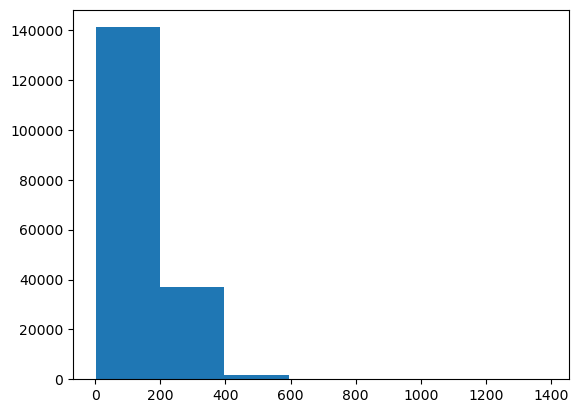

In [34]:
#Check the distribution of our sequence at a character level
import matplotlib.pyplot as plt

plt.hist(chars_lens, bins=7)

In [35]:
# Find the character length that covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [36]:
#Get all keyboard characters
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [37]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS, output_sequence_length=output_seq_char_len, name='char_vectorizer')

In [38]:
char_vectorizer.adapt(train_chars)

In [39]:
#Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common: {char_vocab[:5]}')
print(f'5 least common: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common: ['', '[UNK]', 'e', 't', 'i']
5 least common: ['k', 'x', 'z', 'q', 'j']


### Create a character level embedding

In [40]:
char_embed = Embedding(input_dim=len(char_vocab),
                      output_dim=25, #This is the output for the char embedding from the research paper
                      mask_zero=True,
                      name='char_embed')

### Build the Model

In [121]:
inputs = Input(shape=(1,), dtype='string')
tokenizer = char_vectorizer(inputs)
embed = char_embed(tokenizer)
x = Conv1D(128,8,activation='relu', padding='same')(embed)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs)

In [122]:
tf.random.set_seed(42)

model_3.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer = tf.keras.optimizers.legacy.Adam())

model_3.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_6 (Conv1D)           (None, 290, 128)          25728     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 128)               1651

In [41]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [124]:
tf.random.set_seed(42)

history_3 = model_3.fit(train_char_dataset, epochs=5, validation_data=val_char_dataset)

Epoch 1/5
5627/5627 [==============================] - 56s 10ms/step - loss: 0.7664 - accuracy: 0.7022 - val_loss: 0.6265 - val_accuracy: 0.7664
Epoch 2/5
5627/5627 [==============================] - 56s 10ms/step - loss: 0.6219 - accuracy: 0.7660 - val_loss: 0.6191 - val_accuracy: 0.7719
Epoch 3/5
5627/5627 [==============================] - 56s 10ms/step - loss: 0.5764 - accuracy: 0.7836 - val_loss: 0.6076 - val_accuracy: 0.7790
Epoch 4/5
5627/5627 [==============================] - 56s 10ms/step - loss: 0.5505 - accuracy: 0.7930 - val_loss: 0.6070 - val_accuracy: 0.7766
Epoch 5/5
5627/5627 [==============================] - 52s 9ms/step - loss: 0.5313 - accuracy: 0.8000 - val_loss: 0.5885 - val_accuracy: 0.7859


In [125]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[2.2773120e-01, 5.9265369e-01, 2.8555509e-02, 9.5946625e-02,
        5.5112842e-02],
       [5.4904866e-01, 2.4641748e-01, 8.1020873e-03, 1.7474245e-01,
        2.1689346e-02],
       [4.0063685e-01, 6.0791016e-04, 2.8923438e-03, 5.9561878e-01,
        2.4413031e-04],
       ...,
       [4.7767440e-07, 9.1349866e-05, 1.7625453e-03, 7.9445346e-07,
        9.9814487e-01],
       [5.2010844e-04, 1.8064020e-02, 2.9909359e-02, 4.6087932e-04,
        9.5104569e-01],
       [2.4998426e-03, 9.9346876e-01, 7.7318936e-04, 9.6100155e-04,
        2.2972091e-03]], dtype=float32)

In [126]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 4, 1])>

In [127]:
print(classification_report(val_labels_encoded, model_3_preds))

              precision    recall  f1-score   support

           0       0.63      0.58      0.61      3449
           1       0.74      0.62      0.68      4582
           2       0.84      0.88      0.86      9964
           3       0.78      0.50      0.61      2376
           4       0.79      0.91      0.85      9841

    accuracy                           0.79     30212
   macro avg       0.76      0.70      0.72     30212
weighted avg       0.78      0.79      0.78     30212



## Combining Pretrained token embeddings + Character embeddings

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of the research paper
5. Construct a model which takes token and character level sequences as input and produce sequence label probabilities of ouput

In [42]:
from tensorflow.keras import layers

# Setup the token inputs model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = encoding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

# Create the character level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Combine the models with concatenate
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# Build output layers - add in dropout as in 4.2 from research paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation='softmax')(final_dropout)

# Construct the final model
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input], outputs=output_layer)

In [43]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']   

In [47]:
model_4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.legacy.Adam())

### Combining token and character data into a dataset

In [48]:
#Combine chars and tokens
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data, train_char_token_labels))

#Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [49]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting model with hybrid embeddings

In [55]:
history_4 = model_4.fit(train_char_token_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_char_token_dataset)), validation_data=val_char_token_dataset, validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 29s 51ms/step - loss: 0.7915 - accuracy: 0.6981 - val_loss: 0.7256 - val_accuracy: 0.7281
Epoch 2/5
562/562 [==============================] - 28s 50ms/step - loss: 0.7592 - accuracy: 0.7083 - val_loss: 0.6935 - val_accuracy: 0.7364
Epoch 3/5
562/562 [==============================] - 28s 50ms/step - loss: 0.7562 - accuracy: 0.7095 - val_loss: 0.6807 - val_accuracy: 0.7394
Epoch 4/5
562/562 [==============================] - 28s 50ms/step - loss: 0.7304 - accuracy: 0.7248 - val_loss: 0.6606 - val_accuracy: 0.7493
Epoch 5/5
562/562 [==============================] - 29s 51ms/step - loss: 0.7404 - accuracy: 0.7196 - val_loss: 0.6485 - val_accuracy: 0.7513


In [56]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 11s 10ms/step


array([[5.3170544e-01, 2.3859826e-01, 6.6737402e-03, 2.1439488e-01,
        8.6277192e-03],
       [4.1233420e-01, 4.4935280e-01, 5.0584115e-03, 1.2788005e-01,
        5.3745159e-03],
       [3.1826845e-01, 3.4666885e-02, 6.4133622e-02, 5.6788933e-01,
        1.5041752e-02],
       ...,
       [3.5683109e-04, 2.7701485e-03, 6.6153131e-02, 1.6673804e-04,
        9.3055314e-01],
       [9.6102655e-03, 4.2361300e-02, 3.4710699e-01, 4.2434372e-03,
        5.9667796e-01],
       [2.2583662e-01, 5.5096298e-01, 1.9277522e-01, 1.1197063e-02,
        1.9228131e-02]], dtype=float32)

In [57]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [59]:
from sklearn.metrics import classification_report
print(classification_report(val_labels_encoded, model_4_preds))

              precision    recall  f1-score   support

           0       0.58      0.54      0.56      3449
           1       0.67      0.58      0.62      4582
           2       0.77      0.89      0.83      9964
           3       0.71      0.53      0.61      2376
           4       0.82      0.81      0.81      9841

    accuracy                           0.75     30212
   macro avg       0.71      0.67      0.68     30212
weighted avg       0.74      0.75      0.74     30212



## Model 5 Including positional embeddings

In [60]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [61]:
# Create positional embeddings
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

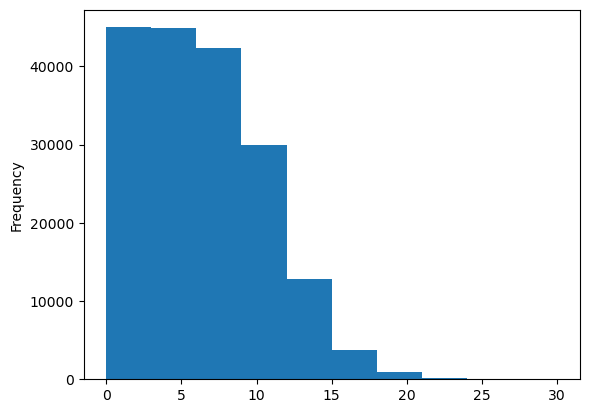

In [64]:
#Check distribution of line number column
train_df.line_number.plot.hist()

In [66]:
# Use TensorFlow to create one hot encoded tensors
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [68]:
train_df['total_lines'].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

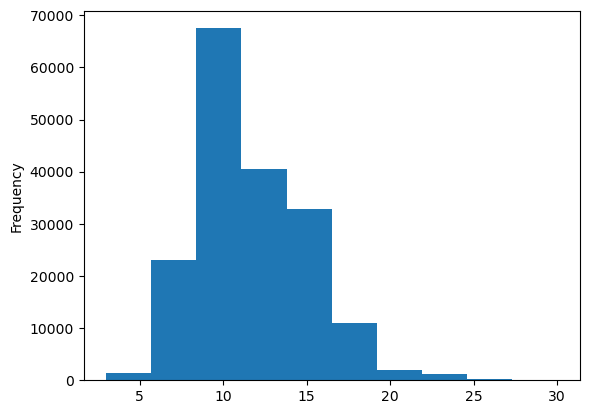

In [69]:
train_df['total_lines'].plot.hist()

In [73]:
train_total_line_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_line_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_line_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_line_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

### Building the TriBrid Embedding model

1. Create token level model
2. Create character level model
3. Create a model for the line number feature
4. Create a model for the total lines feature
5. Combine the outputs of 1&2 using concatenate
6. Combine the outputs of 3, 4, 5 using concat
7. Create output layer to accept the tribred model
8. Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model

In [76]:
train_line_numbers_one_hot.shape, train_total_line_one_hot.shape

(TensorShape([180040, 15]), TensorShape([180040, 20]))

In [92]:
#1 Token level Inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = encoding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2 Char level Inputs
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#3 Line number Inputs
line_inputs = layers.Input(shape=(15,), dtype=tf.float32)
# line_feed = layers.Dense(64, activation='relu')
line_outputs = layers.Dense(32, activation='relu')(line_inputs)
line_model = tf.keras.Model(line_inputs, line_outputs)

#4 Total Lines Inputs
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32)
total_line_outputs = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs)

#5 Combine token and char embeddings into hybrid eembedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid')([token_model.output, char_model.output])
x = layers.Dense(256, activation='relu')(combined_embeddings)
combined_dropout = layers.Dropout(0.5)(x)

#6 Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional')([line_model.output, total_line_model.output, combined_dropout])
# y = layers.Bidirectional(layers.LSTM(24))(tribrid_embeddings)

#7 Create output layer
output_layer = layers.Dense(5, activation='softmax')(tribrid_embeddings)

#8 Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_model.input, total_line_model.input, token_model.input, char_model.input],
                        outputs=output_layer, name='Tribrid_Embedding_Model')

In [93]:
model_5.summary()

Model: "Tribrid_Embedding_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_

In [94]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), metrics=['accuracy'], optimizer = tf.keras.optimizers.legacy.Adam())

In [95]:
# Create Training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_line_one_hot, train_sentences, train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_line_one_hot, val_sentences, val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [96]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [97]:
history_5 = model_5.fit(train_char_token_pos_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)), validation_data=val_char_token_pos_dataset, validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 32s 53ms/step - loss: 1.0964 - accuracy: 0.7219 - val_loss: 0.9871 - val_accuracy: 0.8039
Epoch 2/5
562/562 [==============================] - 29s 51ms/step - loss: 0.9689 - accuracy: 0.8148 - val_loss: 0.9525 - val_accuracy: 0.8231
Epoch 3/5
562/562 [==============================] - 29s 51ms/step - loss: 0.9511 - accuracy: 0.8227 - val_loss: 0.9387 - val_accuracy: 0.8305
Epoch 4/5
562/562 [==============================] - 29s 51ms/step - loss: 0.9395 - accuracy: 0.8337 - val_loss: 0.9325 - val_accuracy: 0.8351
Epoch 5/5
562/562 [==============================] - 29s 51ms/step - loss: 0.9365 - accuracy: 0.8346 - val_loss: 0.9265 - val_accuracy: 0.8421


In [98]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 11s 10ms/step


array([[0.59965914, 0.07942806, 0.01535892, 0.2795003 , 0.02605364],
       [0.6358556 , 0.08002486, 0.07262845, 0.19868319, 0.01280787],
       [0.34360915, 0.10050704, 0.14111803, 0.36575025, 0.0490155 ],
       ...,
       [0.03110188, 0.05442756, 0.03334283, 0.02459825, 0.8565295 ],
       [0.02157629, 0.29239386, 0.09795199, 0.02123627, 0.5668416 ],
       [0.11479076, 0.67241573, 0.11789137, 0.02607216, 0.06882991]],
      dtype=float32)

In [99]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [100]:
print(classification_report(val_labels_encoded, model_5_preds))

              precision    recall  f1-score   support

           0       0.71      0.81      0.75      3449
           1       0.88      0.82      0.85      4582
           2       0.83      0.94      0.88      9964
           3       0.81      0.48      0.61      2376
           4       0.89      0.85      0.87      9841

    accuracy                           0.84     30212
   macro avg       0.83      0.78      0.79     30212
weighted avg       0.84      0.84      0.84     30212



In [101]:
history_6 = model_5.fit(train_char_token_pos_dataset, epochs=5, validation_data=val_char_token_pos_dataset, validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/5
5627/5627 [==============================] - 278s 49ms/step - loss: 0.9190 - accuracy: 0.8471 - val_loss: 0.9085 - val_accuracy: 0.8484
Epoch 2/5
5627/5627 [==============================] - 277s 49ms/step - loss: 0.9024 - accuracy: 0.8594 - val_loss: 0.9036 - val_accuracy: 0.8507
Epoch 3/5
5627/5627 [==============================] - 278s 49ms/step - loss: 0.8928 - accuracy: 0.8664 - val_loss: 0.8995 - val_accuracy: 0.8574
Epoch 4/5
5627/5627 [==============================] - 278s 49ms/step - loss: 0.8855 - accuracy: 0.8719 - val_loss: 0.9013 - val_accuracy: 0.8551
Epoch 5/5
5627/5627 [==============================] - 279s 50ms/step - loss: 0.8794 - accuracy: 0.8764 - val_loss: 0.9004 - val_accuracy: 0.8554


In [102]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_line_one_hot, test_sentences, test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [107]:
model_5_test_pred_probs = model_5.predict(test_char_token_pos_dataset)
model_5_test_pred_probs.shape

942/942 [==============================] - 10s 10ms/step


(30135, 5)

In [114]:
model_5_test_pred_probs[0]

array([0.36032778, 0.09056252, 0.0736318 , 0.35792372, 0.11755422],
      dtype=float32)

In [116]:
model_5_test_preds = tf.argmax(model_5_test_pred_probs, axis=1)
model_5_test_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [105]:
model_5.evaluate(test_char_token_pos_dataset)

942/942 [==============================] - 10s 10ms/step - loss: 0.9050 - accuracy: 0.8504


[0.9049815535545349, 0.8503733277320862]

In [117]:
print(classification_report(test_labels_encoded, model_5_test_preds))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      3621
           1       0.88      0.86      0.87      4571
           2       0.89      0.90      0.89      9897
           3       0.80      0.49      0.61      2333
           4       0.86      0.89      0.88      9713

    accuracy                           0.85     30135
   macro avg       0.83      0.79      0.80     30135
weighted avg       0.85      0.85      0.85     30135

